<h1>Making RNN from Scratch</h1>



---



---




# Planning
1) Initially, get the data 

2) make a dictionary containing values for each word.

3) Convert each sentence into vector

4) Make RNN architecture ->Define inputs and outputs of every neuron

5) The input sentence vector goes into each layer and does forward pass ->Write Forward and Backward pass

6) Make necessary changes for optimization


# Task 1 Get the data 


In [6]:
!unzip "/content/drive/My Drive/Coursera Guided Projects/11827_16290_bundle_archive.zip"

Archive:  /content/drive/My Drive/Coursera Guided Projects/11827_16290_bundle_archive.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


In [7]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import re
from itertools import repeat

In [8]:
data=pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')

In [9]:
df=data[['Clothing ID','Title','Review Text']]
df.head()

,Clothing ID,Title,Review Text
0,767,NaN,Absolutely wonderful - silky and sexy and comf...
1,1080,NaN,Love this dress! it's sooo pretty. i happene...
2,1077,Some major design flaws,I had such high hopes for this dress and reall...
3,1049,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl..."
4,847,Flattering shirt,This shirt is very flattering to all due to th...


# Task 2 make a dictionary containing values for each word

In [10]:
x=list(df['Title'].dropna())
y=list(df['Review Text'].dropna())
#sentence_lengths=[]

l1,l2=[],[]
#Getting all the words in title and review text
for i in range(len(y)):
  if isinstance(y[i], int)==True:
    continue
  else:
    y[i] = y[i].lower()
    p = re.findall(r'(?:\w+)', y[i], flags = re.UNICODE)
    #sentence_lengths.append(len(p))
    for j in range(len(p)): 
      l2.append(p[j]) 

for i in range(len(x)):
  if isinstance(x[i], int)==True:
    continue
  else:
    x[i] = x[i].lower()
    p = re.findall(r'(?:\w+)', x[i], flags = re.UNICODE)
    for j in range(len(p)): 
      l1.append(p[j]) 

#taking unique values only
keys=set(l1).union(set(l2))

#making a dictionary for vectorization
dictionary={key: value for value,key in enumerate(keys)}

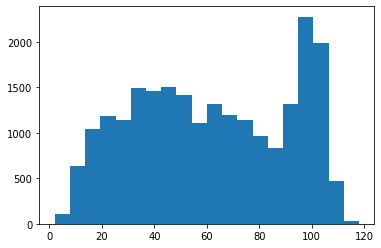

In [11]:
#making vectors of the sentences
#checking average length of the sentences

sentence_lengths=[]
for i in range(len(y)):
    p = re.findall(r'(?:\w+)', y[i], flags = re.UNICODE)
    sentence_lengths.append(len(p))
    
plt.hist(sentence_lengths,bins=20)
plt.show()

Let us consider the average length of Sentences as 100 and continue to make vector of length 100


# Task 3  Convert each sentence into vector

In [12]:
#adding capital o at the end of the dictionary
dictionary['O']=len(dictionary)

In [13]:
#generating empty array to store values
sentence_vectors=np.empty((100))
sentence_vectors=np.expand_dims(sentence_vectors,axis=0)

In [14]:
#making a single vector for all the sentences
for i in y:
  p = re.findall(r'(?:\w+)', i, flags = re.UNICODE)
  if len(p)<100:
    p.extend(repeat('O',100-len(p)))
  words=p[:100]
  vector=[dictionary[word] for word in words] 
  x=np.expand_dims(np.array(vector),axis=0) 
  sentence_vectors=np.concatenate((sentence_vectors,x),axis=0)

In [15]:
#removing the extra row created while initialization
sentence_vectors = np.delete(sentence_vectors, 0, 0)
sentence_vectors.shape

(22641, 100)

In [16]:
no_of_layers=100
vocabsize=14718
seq_length=100 #Tx,Ty
num_examples=22641
no_of_neurons=4 #neurons for wach layer

In [17]:
#convert into one hot vector

#alldata_sentences=np.zeros((num_examples,vocabsize,no_of_layers))
#for i in range(sentence_vectors.shape[0]):
def get_one_hot_encoded_vector(i):  
  sentence=np.zeros((vocabsize,no_of_layers))
  count=0
  for a in sentence_vectors[i][:]:
    my_vec=np.zeros((vocabsize))
    my_vec[int(a)]=1
    sentence[:,count]=my_vec
    count+=1
  return sentence
  #print('o')
  #alldata_sentences[i]=sentence

# Task 4 Make RNN architecture ->Define inputs and outputs of every neuron

need of total 100 layers, as each layer will be given a single word.

Each word of a sentence when goes into the RNN, needs to be one hot encoded

no_of_neurons=100, Vocab_Size=14718,
 Seq_length=100, num_examples=22641

Shapes:
no_of_neurons=4

x = (vocabsize,no_of_layers)

y1 = (vocabsize,no_of_layers)

a = (no_of_neurons,no_of_layers+1)

waa = (no_of_neurons,no_of_layers)

wya = (vocabsize,no_of_neurons,no_of_layers) 

wax = (no_of_neurons,vocabsize,no_of_layers) 

ba = (1,no_of_layers)

by = (1,no_of_layers)

In [18]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0) 

In [ ]:
#newer 
def forward_pass(a,x,wax,wya,waa,ba,by):
  #at timestep t

  #a[t],x[t]-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  a_next = np.tanh(np.dot(waa,a.T)+np.dot(wax,x.T)+ba)
  s_inp=np.dot(wya,a)+by
  y_next = softmax(s_inp)
  loss1 = - x*np.log(y_next) - ((1-x)*np.log(1-y_next))#y[t]=x[t] and ycap[t]=y[t+1]
  loss2 = a_next*np.log(a) #y=a[t+1] and ycap=a[t]
  #print(a)
  #print(np.log(a))
  return a_next,y_next,loss1,loss2

def backward_pass(a,a_next,y_next,x):
  #a[t],x[t],wax,wya,waa,ba,by-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  
  #differentiation of loss function wrt a[t]
  da = np.log(a) #dloss2/da[t+1]
  dy = np.divide(x,y_next) - np.dot( np.log(1-y_next) , (1-np.divide(x,1-y_next)) )#dloss1/dy[t+1])
  dwaa = np.multiply(da,np.multiply(1-np.square(a_next),a)) #dloss2/dwaa waa of time step t
  new_a_next=np.expand_dims(a_next,axis=1)
  new_x=np.expand_dims(x,axis=1)
  new_da=np.expand_dims(da,axis=1)
  dwax = np.multiply(new_da,np.dot(1-np.square(new_a_next),new_x.T)) #dloss2/dwax
  dwya = np.multiply(dy[np.newaxis].T,np.multiply(y_next[np.newaxis].T,np.dot((1-y_next)[np.newaxis].T,a[np.newaxis]))) #dloss1/dwya ->dloss1/dy*dy/dwya
  dba = np.dot(da[np.newaxis],(1-np.square(a_next))[np.newaxis].T) #dloss2/dba
  dby = np.dot(dy[np.newaxis],np.multiply(y_next,(1-y_next))[np.newaxis].T) #dloss1/dby
  return dwaa,dwya,dwax,dba,dby

In [19]:
def differentiation_relu(x):
  x[x>0]=1
  x[x<=0]=0
  return x

In [20]:
#newer 2 
def forward_pass(a,x,wax,wya,waa,ba,by):
  #at timestep t

  #a[t],x[t]-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  #a_next = np.tanh(np.dot(waa,a.T)+np.dot(wax,x.T)+ba)
  a_next = np.maximum((np.dot(waa,a.T)+np.dot(wax,x.T)+ba),0)
  s_inp=np.dot(wya,a)+by
  y_next = softmax(s_inp)
  loss1 = - x*np.log(y_next) - ((1-x)*np.log(1-y_next))#y[t]=x[t] and ycap[t]=y[t+1]
  #loss2 = a_next*np.log(a) #y=a[t+1] and ycap=a[t]
  return a_next,y_next,loss1,loss2

def backward_pass(a,a_next,y_next,x):
  #a[t],x[t],wax,wya,waa,ba,by-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  
  #differentiation of loss function wrt a[t]
  da = np.log(a) #dloss2/da[t+1]
  dy = np.divide(x,y_next) - np.dot( np.log(1-y_next) , (1-np.divide(x,1-y_next)) )#dloss1/dy[t+1])
  dwaa = np.multiply(da,np.multiply(differentiation_relu(a_next),a)) #dloss2/dwaa waa of time step t
  new_a_next=np.expand_dims(a_next,axis=1)
  new_x=np.expand_dims(x,axis=1)
  new_da=np.expand_dims(da,axis=1)
  dwax = np.multiply(new_da,np.dot(differentiation_relu(new_a_next),new_x.T)) #dloss2/dwax
  dwya = np.multiply(dy[np.newaxis].T,np.multiply(y_next[np.newaxis].T,np.dot((1-y_next)[np.newaxis].T,a[np.newaxis]))) #dloss1/dwya ->dloss1/dy*dy/dwya
  dba = np.dot(da[np.newaxis],(differentiation_relu(a_next))[np.newaxis].T) #dloss2/dba
  dby = np.dot(dy[np.newaxis],np.multiply(y_next,(1-y_next))[np.newaxis].T) #dloss1/dby
  return dwaa,dwya,dwax,dba,dby

In [21]:
def model_params_init():
  #x=sentence#(vocabsize,no_of_layers)
  x=np.zeros((vocabsize,no_of_layers))
  y1=np.zeros((vocabsize,no_of_layers))
  a = np.random.uniform(0, 1, (no_of_neurons,no_of_layers+1))
  waa = np.random.uniform(0, 1, (no_of_neurons,no_of_layers)) 
  wya = np.random.uniform(0, 1, (vocabsize,no_of_neurons,no_of_layers)) 
  wax = np.random.uniform(0, 1, (no_of_neurons,vocabsize,no_of_layers)) 
  ba = np.random.uniform(0, 1, (1,no_of_layers))
  by = np.random.uniform(0, 1, (1,no_of_layers))
  outputs = np.zeros((vocabsize, no_of_layers))
  return x,y1,a,waa,wya,wax,ba,by,outputs

In [22]:
#defining the architecture of RNN
def model_train(epochs,learning_rate):
  x,y1,a,waa,wya,wax,ba,by,outputs=model_params_init()
  for j in range(epochs):
    total_loss1=[]
    total_loss2=[]
    count=0
    for i in range(num_examples):
      x=get_one_hot_encoded_vector(i)#(vocabsize,no_of_layers)

      #forward pass for a single sentence
      for t in range(0,no_of_layers):
        print(a[:,t])
        a[:,t+1],y1[:,t],loss1,loss2=forward_pass(a[:,t],x[:,t],wax[:,:,t],wya[:,:,t],waa[:,t],ba[0,t],by[0,t] )#perform forward pass at instant t
        total_loss1.append(loss1)
        total_loss2.append(loss2)
        #forward pass should return y,a[t+1] and loss
      
      #backward pass for a single sentence
      for t in range(no_of_layers-1,0,-1):
        #t->t-1
        dwaa,dwya,dwax,dba,dby=backward_pass(a[:,t-1],a[:,t],y1[:,t],x[:,t-1])
        alpha=learning_rate
        #backward pass will update weights of every layer --> need to add timestep to them, like update entire column no. t-1 (waa,wax,wya)
        #weight updation
        waa[:,t-1] = waa[:,t-1] + alpha*dwaa#(4,1)
        wax[:,:,t-1] = wax[:,:,t-1] + alpha*dwax#(4,14718)
        wya[:,:,t-1] = wya[:,:,t-1] + alpha*dwya#(14718,4)
        ba[0,t-1] = ba[0,t-1] + alpha*dba
        by[0,t-1] = by[0,t-1] + alpha*dby
        #break
      #break
      print('example '+str(i)+'/'+str(num_examples)+' completed')
      count+=1
      if count==10:
        break
    print('epoch '+str(j)+' completed')
    print('average vertical loss',sum(total_loss1)/(len(total_loss1)+1))
    print('average horizontal loss',sum(total_loss2)/(len(total_loss2)+1))
  return waa,wax,wya,ba,by,a
  #return a,y1,x

In [23]:
epochs=1
learning_rate=0.3
model=model_train(epochs,learning_rate)

[0.78511972 0.23882618 0.15468438 0.30820297]
[1.07789878 1.55837824 1.42741612 1.18110974]
[4.89553964 5.42628306 5.55334768 5.51666208]
[16.43639073 16.38548389 16.64781784 15.96081036]
[48.47365991 47.85581554 47.90642589 47.96215553]
[122.54777305 121.763673   121.86851363 121.94068408]
[240.22300373 239.98260834 240.27590062 240.55302902]
[349.62191934 349.43984258 349.82992394 349.74156658]
[491.9054472  491.49551795 492.14800496 491.9715944 ]
[780.42545127 780.16599997 780.38695535 780.79364519]
[2899.02328091 2899.93400877 2899.79081519 2899.3400569 ]
[6549.44325792 6549.47914557 6549.53170675 6549.71371893]
[13461.14750315 13461.36457727 13461.48731807 13460.96941145]
[15668.78391887 15669.31660044 15668.81147144 15669.47896561]
[27943.51923778 27943.83237677 27943.89764394 27943.38192059]
[59010.15474842 59010.00216999 59009.82640474 59009.78487032]
[64836.63034388 64836.50843124 64836.89235411 64836.3637187 ]
[155318.15189622 155317.51649376 155317.39921042 155317.46914541]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


[2.44270943e+17 2.44270943e+17 2.44270943e+17 2.44270943e+17]
[5.07900501e+17 5.07900501e+17 5.07900501e+17 5.07900501e+17]
[1.23153216e+18 1.23153216e+18 1.23153216e+18 1.23153216e+18]
[3.6293113e+18 3.6293113e+18 3.6293113e+18 3.6293113e+18]
[5.73198866e+18 5.73198866e+18 5.73198866e+18 5.73198866e+18]
[1.33720497e+19 1.33720497e+19 1.33720497e+19 1.33720497e+19]
[2.52060731e+19 2.52060731e+19 2.52060731e+19 2.52060731e+19]
[2.27459886e+19 2.27459886e+19 2.27459886e+19 2.27459886e+19]
[5.17408718e+19 5.17408718e+19 5.17408718e+19 5.17408718e+19]
[8.04449513e+19 8.04449513e+19 8.04449513e+19 8.04449513e+19]
[2.0563415e+20 2.0563415e+20 2.0563415e+20 2.0563415e+20]
[4.59404704e+20 4.59404704e+20 4.59404704e+20 4.59404704e+20]
[1.00298932e+21 1.00298932e+21 1.00298932e+21 1.00298932e+21]
[1.55190096e+21 1.55190096e+21 1.55190096e+21 1.55190096e+21]
[5.01463221e+21 5.01463221e+21 5.01463221e+21 5.01463221e+21]
[5.20501377e+21 5.20501377e+21 5.20501377e+21 5.20501377e+21]
[1.05654143e+22 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


example 0/22641 completed
[0.78511972 0.23882618 0.15468438 0.30820297]
[0. 0. 0. 0.]
[1.64041717 1.62444036 1.84643715 1.74245779]
[26.17709666 26.16356372 26.32971596 26.65659503]
[1523.84283679 1524.44260348 1524.34367998 1523.8239415 ]
[344141.80102695 344141.31189774 344141.17342912 344141.94633328]
[2.42784269e+08 2.42784270e+08 2.42784270e+08 2.42784269e+08]
[3.84056969e+11 3.84056969e+11 3.84056969e+11 3.84056969e+11]
[9.44366787e+14 9.44366787e+14 9.44366787e+14 9.44366787e+14]
[3.45650766e+18 3.45650766e+18 3.45650766e+18 3.45650766e+18]
[2.15716677e+22 2.15716677e+22 2.15716677e+22 2.15716677e+22]
[5.98425979e+26 5.98425979e+26 5.98425979e+26 5.98425979e+26]
[4.13298279e+31 4.13298279e+31 4.13298279e+31 4.13298279e+31]
[6.34750131e+36 6.34750131e+36 6.34750131e+36 6.34750131e+36]
[1.15288107e+42 1.15288107e+42 1.15288107e+42 1.15288107e+42]
[3.95789705e+47 3.95789705e+47 3.95789705e+47 3.95789705e+47]
[3.07885926e+53 3.07885926e+53 3.07885926e+53 3.07885926e+53]
[2.65410191e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


example 1/22641 completed
[0.78511972 0.23882618 0.15468438 0.30820297]
[0.         0.02375976 0.         0.        ]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add


In [ ]:
def model_predict(model):
  x,y1,a,waa,wya,wax,ba,by,outputs=model_params_init()
  waa,wax,wya,ba,by,a=model
  x=get_one_hot_encoded_vector(0)#i th values sentece chosen 
  #forward pass for a single sentence
  for t in range(0,no_of_layers):
    a[:,t+1],y1[:,t],loss1,loss2=forward_pass(a[:,t],x[:,t],wax[:,:,t],wya[:,:,t],waa[:,t],ba[0,t],by[0,t] )#perform forward pass at instant t
    #total_loss1.append(loss1)
    #total_loss2.append(loss2)
  print('actual sentece: '+ vector_to_sentence(x))
  print('predicted sentece: '+ vector_to_sentence(y1))

In [ ]:
model_predict(model)

actual sentece: absolutely wonderful silky and sexy and comfortable O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 
predicted sentece: firstly had sucked very everyth matetial all prim stitches orde skinnys fabulous restriction coke resisted pictu i i fan O petite bc crunchy O O O O O this O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O sink 


In [ ]:
#output vector to sentence
def vector_to_sentence(y):
  key_list = list(dictionary.keys()) 
  val_list = list(dictionary.values())
  op_sentence=''
  for i in range(no_of_layers):
    avec=y[:,i]
    word_value=np.argmax(avec)
    word=key_list[val_list.index(word_value)]
    #print(word)
    op_sentence=op_sentence+word+" "
  return op_sentence

# Task 5 The input sentence vector goes into each layer and does forward pass ->Write Forward and Backward pass


In [ ]:
def forward_pass(a,x,wax,wya,waa,ba,by):
  #at timestep t

  #a[t],x[t],wax,wya,waa,ba,by-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  a_next = np.tanh(waa*a+wax*x+ba)
  wya=np.expand_dims(wya,axis=1)
  s_inp=np.dot(wya,a[np.newaxis])+by
  y_next = softmax(s_inp)

  #y_next = softmax(np.dot(wya,a)+by)
  loss1 = - x*np.log(y_next) - ((1-x)*np.log(1-y_next))#y[t]=x[t] and ycap[t]=y[t+1]
  loss2 = a_next*np.log(a) #y=a[t+1] and ycap=a[t]

  print(a_next.shape)
  print(y_next.shape)
  return a_next,y_next,loss1,loss2

def backward_pass(a,a_next,y_next,x):
  #a[t],x[t],wax,wya,waa,ba,by-->a,x
  #a[t+1],y[t+1]-->a_next,y_next
  
  #differentiation of loss function wrt a[t]
  da = np.log(a) #dloss2/da[t+1]
  dy = x/y_next - ( np.log(1-y_next) * (1-x[t]/1-y_next) )#dloss1/dy[t+1])
  dwaa = da*((1-(a_next**2))*a) #dloss2/dwaa waa of time step t
  dwax = da*((1-(a_next**2))*x) #dloss2/dwax
  dwya = dy*y_next*(1-y_next)*a #dloss1/dwya ->dloss1/dy*dy/dwya
  dba = da*(1-(a_next**2)) #dloss2/dba
  dby = dy*y_next*(1-y_next) #dloss1/dby
  return dwaa,dwya,dwax,dba,dby